In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install open3d==0.16.0  # or a compatible version
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


INFO: pip is looking at multiple versions of nbconvert to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of nbconvert to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.5/422.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.9/285.9 kB 24.5 MB

In [ ]:
def off_to_voxel(off_path, grid_size=16):
    """
    Convert an .off file to a voxel grid using Open3D.
    """
    try:
        mesh = o3d.io.read_triangle_mesh(off_path)
        if mesh.is_empty():
            print(f"Mesh is empty for file: {off_path}")
            return None

        # Normalize mesh to fit within [0,1]
        bounds = mesh.get_max_bound() - mesh.get_min_bound()
        scale_factor = 1.0 / max(bounds)
        mesh.scale(scale_factor, center=mesh.get_center())
        translation = -mesh.get_min_bound() * scale_factor
        mesh.translate(translation)

        # Create voxel grid
        voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=1.0 / grid_size)

        # Convert voxel grid to numpy
        voxel_numpy = np.zeros((grid_size, grid_size, grid_size), dtype=np.uint8)
        for voxel in voxel_grid.get_voxels():
            x, y, z = voxel.grid_index
            # Ensure indices are in bounds
            if 0 <= x < grid_size and 0 <= y < grid_size and 0 <= z < grid_size:
                voxel_numpy[x, y, z] = 1
        return voxel_numpy

    except Exception as e:
        print(f"Error processing {off_path}: {e}")
        return None


def load_dataset(data_dir, grid_size=16):
    """
    Loads the ModelNet dataset from .off files, converts to voxel grids.
    Returns np arrays: voxel_data, labels
    """
    voxel_data = []
    labels = []
    classes = ['chair']
    for label, cls in enumerate(classes):
        class_dir = os.path.join(data_dir, cls)
        if os.path.isdir(class_dir):
            for split in ['train', 'test']:
                split_dir = os.path.join(class_dir, split)
                if not os.path.isdir(split_dir):
                    print(f"Split directory {split_dir} missing. Skipping...")
                    continue
                print(f"Processing class: {cls}, split: {split}")
                for file in os.listdir(split_dir):
                    if file.endswith(".off"):
                        file_path = os.path.join(split_dir, file)
                        voxel = off_to_voxel(file_path, grid_size)
                        if voxel is not None:
                            voxel_data.append(voxel)
                            labels.append(label)
    return np.array(voxel_data), np.array(labels)


In [ ]:
data_dir = "/content/drive/MyDrive/ModelNet10"
grid_size = 16
voxels, labels = load_dataset(data_dir, grid_size=grid_size)
print("Loaded voxel shape:", voxels.shape, "labels shape:", labels.shape)

Processing class: chair, split: train
Processing class: chair, split: test
Loaded voxel shape: (989, 16, 16, 16) labels shape: (989,)


In [ ]:
class VoxelsDataset(Dataset):
    def __init__(self, voxel_data, labels=None):
        """
        voxel_data: np array of shape (N, D, D, D)
        labels: np array of shape (N,) or None if unconditional
        """
        self.data = voxel_data.astype(np.float32)
        self.labels = labels
        self.data = np.expand_dims(self.data, axis=1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        if self.labels is not None:
            y = self.labels[idx]
            return x, y
        else:
            return x


In [ ]:
dataset = VoxelsDataset(voxels, labels)
print("Dataset length:", len(dataset))


Dataset length: 989


In [ ]:
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


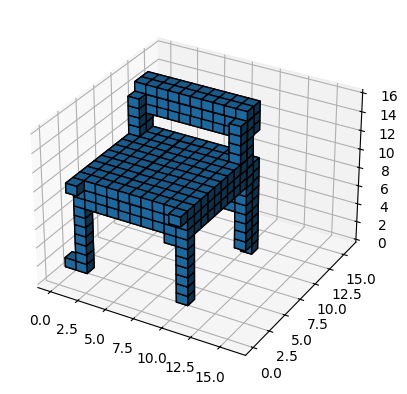

In [ ]:
import matplotlib.pyplot as plt

def visualize_voxel(voxel):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(voxel, edgecolor='k')
    plt.show()

visualize_voxel(voxels[57])

In [ ]:
class Generator3D(nn.Module):
    def __init__(self, latent_dim=100, base_channels=64):
        super(Generator3D, self).__init__()
        self.latent_dim = latent_dim
        self.net = nn.Sequential(
            nn.ConvTranspose3d(latent_dim, base_channels*8, 2, 1, 0, bias=False),
            nn.BatchNorm3d(base_channels*8),
            nn.ReLU(True),

            nn.ConvTranspose3d(base_channels*8, base_channels*4, 2, 2, 0, bias=False),
            nn.BatchNorm3d(base_channels*4),
            nn.ReLU(True),

            nn.ConvTranspose3d(base_channels*4, base_channels*2, 2, 2, 0, bias=False),
            nn.BatchNorm3d(base_channels*2),
            nn.ReLU(True),

            nn.ConvTranspose3d(base_channels*2, base_channels, 2, 2, 0, bias=False),
            nn.BatchNorm3d(base_channels),
            nn.ReLU(True),

            nn.Conv3d(base_channels, 1, 3, 1, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, z):
        z = z.view(z.size(0), self.latent_dim, 1, 1, 1)
        return self.net(z)

class Discriminator3D(nn.Module):
    def __init__(self, base_channels=64):
        super(Discriminator3D, self).__init__()
        self.net = nn.Sequential(
            nn.Conv3d(1, base_channels, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(base_channels, base_channels*2, 4, 2, 1, bias=False),
            nn.BatchNorm3d(base_channels*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(base_channels*2, base_channels*4, 4, 2, 1, bias=False),
            nn.BatchNorm3d(base_channels*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(base_channels*4, base_channels*8, 2, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(base_channels*8, 1, 1, 1, 0, bias=False),
        )

    def forward(self, x):
        out = self.net(x).view(-1)  # shape (N,)
        return out


In [ ]:
def train_3d_gan(dataloader, epochs=5, latent_dim=100, lr=0.0002, checkpoint_dir="/content/checkpoints"):
    os.makedirs(checkpoint_dir, exist_ok=True)

    G = Generator3D(latent_dim=latent_dim).to(device)
    D = Discriminator3D().to(device)

    criterion = nn.BCEWithLogitsLoss()
    optim_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    optim_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for i, (real_batch, _) in enumerate(dataloader):
            real_batch = real_batch.to(device)  # shape: (N,1,16,16,16)
            N = real_batch.size(0)
            # Train Discriminator
            D.zero_grad()

            labels_real = torch.ones(N, device=device)
            labels_fake = torch.zeros(N, device=device)

            pred_real = D(real_batch)
            loss_D_real = criterion(pred_real, labels_real)

            z = torch.randn(N, latent_dim, device=device)
            fake = G(z)
            pred_fake = D(fake.detach())
            loss_D_fake = criterion(pred_fake, labels_fake)

            loss_D = loss_D_real + loss_D_fake
            loss_D.backward()
            optim_D.step()

            # Train Generator
            G.zero_grad()
            pred_fake_for_G = D(fake)
            loss_G = criterion(pred_fake_for_G, labels_real)
            loss_G.backward()
            optim_G.step()

            if i % 50 == 0:
                print(f"Epoch [{epoch}/{epochs}] Step [{i}/{len(dataloader)}] "
                      f"D Loss: {loss_D.item():.4f}, G Loss: {loss_G.item():.4f}")

        # Save checkpoints each epoch
        torch.save(G.state_dict(), os.path.join(checkpoint_dir, f"generator_epoch_{epoch}.pth"))
        torch.save(D.state_dict(), os.path.join(checkpoint_dir, f"discriminator_epoch_{epoch}.pth"))
        print(f"Saved checkpoint for epoch {epoch}")

    return G, D


In [ ]:
checkpoint_dir = "/content/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

epochs = 5
latent_dim = 100
lr = 0.0002

G, D = train_3d_gan(dataloader, epochs=epochs, latent_dim=latent_dim, lr=lr, checkpoint_dir=checkpoint_dir)


Epoch [0/5] Step [0/62] D Loss: 1.4281, G Loss: 2.8575
Epoch [0/5] Step [50/62] D Loss: 0.0381, G Loss: 6.9569
Saved checkpoint for epoch 0
Epoch [1/5] Step [0/62] D Loss: 0.0718, G Loss: 7.2029
Epoch [1/5] Step [50/62] D Loss: 0.1772, G Loss: 5.1118
Saved checkpoint for epoch 1
Epoch [2/5] Step [0/62] D Loss: 0.5949, G Loss: 6.8596
Epoch [2/5] Step [50/62] D Loss: 0.5745, G Loss: 5.5888
Saved checkpoint for epoch 2
Epoch [3/5] Step [0/62] D Loss: 0.5291, G Loss: 7.4037
Epoch [3/5] Step [50/62] D Loss: 0.4080, G Loss: 3.3466
Saved checkpoint for epoch 3
Epoch [4/5] Step [0/62] D Loss: 0.6151, G Loss: 6.6212
Epoch [4/5] Step [50/62] D Loss: 0.6995, G Loss: 2.5831
Saved checkpoint for epoch 4


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def voxel2points(voxel, threshold=0.5):
    """
    Convert a 3D voxel grid (DxDxD) into a set of surface (X, Y, Z) points.
    Each voxel above 'threshold' is considered "filled".

    A voxel is deemed a surface point if it has at least one neighboring voxel
    that is below the threshold (i.e., not filled), indicating an exposed face.
    """
    # voxel is expected to be shape (D, D, D)
    D, M, N = voxel.shape
    # Binarize the voxel data
    filled_positions = np.where(voxel > threshold)

    # Convert to integer mask for easier neighbor checking
    bin_voxel = np.zeros_like(voxel, dtype=np.uint8)
    bin_voxel[filled_positions] = 1

    X, Y, Z = [], [], []
    for x, y, z in zip(*filled_positions):
        # Extract a 3x3x3 neighborhood around (x,y,z)
        x_min, x_max = max(x - 1, 0), min(x + 2, D)
        y_min, y_max = max(y - 1, 0), min(y + 2, M)
        z_min, z_max = max(z - 1, 0), min(z + 2, N)
        neighborhood = bin_voxel[x_min:x_max, y_min:y_max, z_min:z_max]

        # If at least one neighbor is empty, this is a surface voxel
        if np.sum(neighborhood) < neighborhood.size:
            X.append(x)
            Y.append(y)
            Z.append(z)
    return np.array(X), np.array(Y), np.array(Z)

def visualize_voxel(voxel, threshold=0.5, colormap='viridis', show_plot=True, save_path=None):
    """
    Create a 3D scatter plot of the surface points of the voxel volume.

    Args:
        voxel (numpy.ndarray): 3D array (D,D,D), where values > threshold are considered filled.
        threshold (float): Threshold for binarizing voxel data.
        colormap (str): Matplotlib colormap name for coloring the scatter points.
        show_plot (bool): Whether to display the plot inline (True) or close immediately (False).
        save_path (str or None): File path to save the figure as a .png (if desired).
    """
    X, Y, Z = voxel2points(voxel, threshold=threshold)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(X, Y, Z, c=Z, cmap=colormap, s=25, marker='.')

    # Optionally remove axes / cosmetic cleanup
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.grid(False)
    ax.set_box_aspect([1,1,1])  # ensures equal aspect ratio along all axes
    plt.title("3D Voxel Visualization")

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Figure saved to {save_path}")

    if show_plot:
        plt.show()
    else:
        plt.close(fig)

# Example usage:
# voxel_array = np.random.rand(16,16,16)  # for demonstration
# visualize_voxel(voxel_array, threshold=0.5, colormap='viridis', show_plot=True)


In [ ]:
def generate_samples(checkpoint_path, latent_dim=100, num_samples=1):
    # Re-instantiate generator
    G = Generator3D(latent_dim=latent_dim).to(device)
    G.load_state_dict(torch.load(checkpoint_path, map_location=device))
    G.eval()

    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim, device=device)
        fake = G(z).cpu().numpy()  # shape: (num_samples,1,16,16,16)

    for i in range(num_samples):
        voxel_volume = fake[i, 0]
        print(f"Generated sample {i} shape:", voxel_volume.shape)
        visualize_voxel(voxel_volume, threshold=0.5, colormap='viridis')


Generated sample 0 shape: (16, 16, 16)


<ipython-input-28-8952f136ba0b>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load(checkpoint_path, map_location=device))


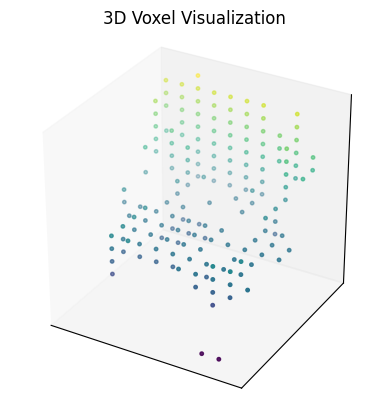

In [ ]:
generate_samples("/content/checkpoints/generator_epoch_4.pth", latent_dim=100, num_samples=1)

